In [1]:
# 让notebook宽屏显示
from IPython.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

In [2]:
import pandas as pd
import numpy as np
import datetime
import xgboost as xgb
from xgboost import plot_importance
import operator
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import toad
import warnings
warnings.filterwarnings("ignore")

/Users/limeng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
validation_train=pd.read_csv('./validation_train_9.csv',index_col=0)
validation_test=pd.read_csv('./validation_test_9.csv',index_col=0)
train=validation_train.drop(columns='date')
test=validation_test.copy()
train

,target,id,id_card_isnull_x,phone_isnull_x,auth_time_isnull,auth_info_notnull_num,card_1_cnt,card_2_cnt,id_bank_cnt,id_phone_set_x,...,account_grade_two,account_grade_three,account_grade_four,account_grade_five,days,days_is_neg,years,years_is_neg,time_days_mean,time_days_mean_is_neg
0,0,20160608150003808365,1,1,1,3,4,2,6,1,...,0,0,0,0,129,1,0,0,318.461538,1
1,0,20160427110002485018,1,1,1,3,3,2,5,1,...,1,0,0,0,-417,0,-1,0,1103.000000,1
2,0,593852820159991816,0,1,0,1,2,3,5,1,...,0,0,0,0,0,0,0,0,-1.000000,0
3,0,506970882778861832,1,1,1,3,1,2,3,1,...,0,0,0,0,-380,0,-1,0,-1.000000,0
4,0,584688602999427336,1,1,1,3,1,0,1,1,...,0,1,0,0,56,1,0,0,-1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88757,0,576751542485389576,1,1,1,3,1,0,1,1,...,1,0,0,0,228,1,1,1,48.200000,1
88758,0,590710366225305608,0,1,0,1,2,0,2,1,...,0,0,0,0,0,0,0,0,-1.000000,0
88759,0,578853574977523976,0,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,-1.000000,0
88760,0,492795832240705800,1,0,0,1,0,1,1,1,...,1,0,0,0,0,0,0,0,-1.000000,0


### 特征筛选

In [5]:
ex_lis=['id']

In [7]:
feature_1, drop_lst= toad.selection.select(train, train['target'], 
                                                   empty=0.7, iv=0.01, 
                                                   corr=0.7, 
                                                   return_drop=True, 
                                                   exclude=ex_lis)  
print("keep:", feature_1.shape[1],  
      "drop empty:", len(drop_lst['empty']), 
      "drop iv:", len(drop_lst['iv']),  
      "drop corr:", len(drop_lst['corr'])) 

keep: 29 drop empty: 0 drop iv: 26 drop corr: 12


In [11]:
feature_1_col=train.columns

Index(['target', 'id', 'auth_info_notnull_num', 'card_1_cnt', 'card_2_cnt',
       'id_card_set', 'credit_score', 'quota', 'q_o', 'way1_cnt',
       'id_sts_order_set', 'cheng_gong_cnt', 'qu_xiao_cnt', 'phone_isnull_y',
       'fix_phone_isnull', 'id_phone_set', 'province_len', '高中', '0000-00-00',
       'merriage1', 'income3', 'id_card_isnull_y', 'wechat_bound_two',
       'account_grade_one', 'account_grade_two', 'days', 'days_is_neg',
       'time_days_mean', 'time_days_mean_is_neg'],
      dtype='object')

- 分别对不同月份数据，使用xgb进行特征筛选，取平均分数

In [9]:
def xgb_feature_select(train_data,train_target,test_data,test_target):
    xgb_train = xgb.DMatrix(train_data, label=train_target)
    xgb_test = xgb.DMatrix(test_data, label=test_target)
    watchlist = [(xgb_train, 'train'), (xgb_test, 'val')]
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'gamma': 0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
        'max_depth': 5,  # 构建树的深度，越大越容易过拟合
        'lambda': 2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
        'subsample': 0.8,  # 随机采样训练样本
        'colsample_bytree': 0.8,  # 生成树时进行的列采样
        'min_child_weight': 18,
        'silent': 0,  # 设置成1则没有运行信息输出，最好是设置为0.
        'eta': 0.03,  # 如同学习率
        'eval_metric': 'auc',
    }
    model = xgb.train(params, xgb_train, num_boost_round=500, evals=watchlist)
    features = model.get_fscore()
    
    return features

In [12]:
validation_test_features = test[feature_1_col].drop(columns=['target', 'id'])
validation_test_target = test['target']

In [13]:
df_importance_list=[]
for i in set(validation_train['date']):   
    #定义模型训练集
    validation_train_data=validation_train[validation_train['date']==i]
    validation_train_target= validation_train_data[['target']]
    
    validation_train_data = validation_train_data.drop(['target', 'id','date'], axis=1) 
    

    validation_test_data=validation_test_features
    validation_test_target=validation_test_target
    #调用模型进行训练
    features=xgb_feature_select(validation_train_data,validation_train_target,validation_test_data,validation_test_target)
    
    features = pd.DataFrame(
                {'name' : features.keys(),
                'importance' : features.values()
              }).sort_values(by =  ['importance'],ascending = False)
    
    #a=a.merge(features,how='inner',on='name')
    df_importance_list.append(features)

[21:18:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.50000	val-auc:0.50000
[1]	train-auc:0.50000	val-auc:0.50000
[2]	train-auc:0.50000	val-auc:0.50000
[3]	train-auc:0.50000	val-auc:0.50000
[4]	train-auc:0.50000	val-auc:0.50000
[5]	train-auc:0.50000	val-auc:0.50000
[6]	train-auc:0.50000	val-auc:0.50000
[7]	train-auc:0.50000	val-auc:0.50000
[8]	train-auc:0.50000	val-auc:0.50000
[9]	train-auc:0.50000	val-auc:0.50000
[10]	train-auc:0.50000	val-auc:0.50000
[11]	train-auc:0.50000	val-auc:0.50000
[12]	train-auc:0.50000	val-auc:0.50000
[13]	train-auc:0.50000	val-auc:0.50000
[14]	train-

[197]	train-auc:0.50000	val-auc:0.50000
[198]	train-auc:0.50000	val-auc:0.50000
[199]	train-auc:0.50000	val-auc:0.50000
[200]	train-auc:0.50000	val-auc:0.50000
[201]	train-auc:0.50000	val-auc:0.50000
[202]	train-auc:0.50000	val-auc:0.50000
[203]	train-auc:0.50000	val-auc:0.50000
[204]	train-auc:0.50000	val-auc:0.50000
[205]	train-auc:0.50000	val-auc:0.50000
[206]	train-auc:0.50000	val-auc:0.50000
[207]	train-auc:0.50000	val-auc:0.50000
[208]	train-auc:0.50000	val-auc:0.50000
[209]	train-auc:0.50000	val-auc:0.50000
[210]	train-auc:0.50000	val-auc:0.50000
[211]	train-auc:0.50000	val-auc:0.50000
[212]	train-auc:0.50000	val-auc:0.50000
[213]	train-auc:0.50000	val-auc:0.50000
[214]	train-auc:0.50000	val-auc:0.50000
[215]	train-auc:0.50000	val-auc:0.50000
[216]	train-auc:0.50000	val-auc:0.50000
[217]	train-auc:0.50000	val-auc:0.50000
[218]	train-auc:0.50000	val-auc:0.50000
[219]	train-auc:0.50000	val-auc:0.50000
[220]	train-auc:0.50000	val-auc:0.50000
[221]	train-auc:0.50000	val-auc:0.50000


[402]	train-auc:0.50000	val-auc:0.50000
[403]	train-auc:0.50000	val-auc:0.50000
[404]	train-auc:0.50000	val-auc:0.50000
[405]	train-auc:0.50000	val-auc:0.50000
[406]	train-auc:0.50000	val-auc:0.50000
[407]	train-auc:0.50000	val-auc:0.50000
[408]	train-auc:0.50000	val-auc:0.50000
[409]	train-auc:0.50000	val-auc:0.50000
[410]	train-auc:0.50000	val-auc:0.50000
[411]	train-auc:0.50000	val-auc:0.50000
[412]	train-auc:0.50000	val-auc:0.50000
[413]	train-auc:0.50000	val-auc:0.50000
[414]	train-auc:0.50000	val-auc:0.50000
[415]	train-auc:0.50000	val-auc:0.50000
[416]	train-auc:0.50000	val-auc:0.50000
[417]	train-auc:0.50000	val-auc:0.50000
[418]	train-auc:0.50000	val-auc:0.50000
[419]	train-auc:0.50000	val-auc:0.50000
[420]	train-auc:0.50000	val-auc:0.50000
[421]	train-auc:0.50000	val-auc:0.50000
[422]	train-auc:0.50000	val-auc:0.50000
[423]	train-auc:0.50000	val-auc:0.50000
[424]	train-auc:0.50000	val-auc:0.50000
[425]	train-auc:0.50000	val-auc:0.50000
[426]	train-auc:0.50000	val-auc:0.50000


[99]	train-auc:0.79197	val-auc:0.68504
[100]	train-auc:0.79213	val-auc:0.68500
[101]	train-auc:0.79276	val-auc:0.68521
[102]	train-auc:0.79299	val-auc:0.68580
[103]	train-auc:0.79348	val-auc:0.68604
[104]	train-auc:0.79361	val-auc:0.68637
[105]	train-auc:0.79434	val-auc:0.68591
[106]	train-auc:0.79446	val-auc:0.68610
[107]	train-auc:0.79513	val-auc:0.68730
[108]	train-auc:0.79500	val-auc:0.68660
[109]	train-auc:0.79548	val-auc:0.68595
[110]	train-auc:0.79549	val-auc:0.68553
[111]	train-auc:0.79584	val-auc:0.68574
[112]	train-auc:0.79619	val-auc:0.68555
[113]	train-auc:0.79693	val-auc:0.68631
[114]	train-auc:0.79689	val-auc:0.68626
[115]	train-auc:0.79676	val-auc:0.68650
[116]	train-auc:0.79683	val-auc:0.68606
[117]	train-auc:0.79716	val-auc:0.68650
[118]	train-auc:0.79724	val-auc:0.68720
[119]	train-auc:0.79747	val-auc:0.68731
[120]	train-auc:0.79840	val-auc:0.68734
[121]	train-auc:0.79866	val-auc:0.68777
[122]	train-auc:0.79823	val-auc:0.68735
[123]	train-auc:0.79857	val-auc:0.68828
[

[304]	train-auc:0.81921	val-auc:0.68732
[305]	train-auc:0.81924	val-auc:0.68717
[306]	train-auc:0.81946	val-auc:0.68734
[307]	train-auc:0.81969	val-auc:0.68788
[308]	train-auc:0.82001	val-auc:0.68848
[309]	train-auc:0.82003	val-auc:0.68890
[310]	train-auc:0.82011	val-auc:0.68841
[311]	train-auc:0.82029	val-auc:0.68842
[312]	train-auc:0.82028	val-auc:0.68867
[313]	train-auc:0.82042	val-auc:0.68834
[314]	train-auc:0.82044	val-auc:0.68879
[315]	train-auc:0.82052	val-auc:0.68968
[316]	train-auc:0.82065	val-auc:0.68944
[317]	train-auc:0.82099	val-auc:0.68938
[318]	train-auc:0.82112	val-auc:0.68908
[319]	train-auc:0.82134	val-auc:0.68865
[320]	train-auc:0.82147	val-auc:0.68887
[321]	train-auc:0.82153	val-auc:0.68863
[322]	train-auc:0.82184	val-auc:0.68888
[323]	train-auc:0.82213	val-auc:0.68861
[324]	train-auc:0.82236	val-auc:0.68902
[325]	train-auc:0.82229	val-auc:0.68899
[326]	train-auc:0.82237	val-auc:0.68951
[327]	train-auc:0.82246	val-auc:0.68907
[328]	train-auc:0.82231	val-auc:0.68877


[0]	train-auc:0.50000	val-auc:0.50000
[1]	train-auc:0.50000	val-auc:0.50000
[2]	train-auc:0.50000	val-auc:0.50000
[3]	train-auc:0.50000	val-auc:0.50000
[4]	train-auc:0.50000	val-auc:0.50000
[5]	train-auc:0.50000	val-auc:0.50000
[6]	train-auc:0.50000	val-auc:0.50000
[7]	train-auc:0.50000	val-auc:0.50000
[8]	train-auc:0.50000	val-auc:0.50000
[9]	train-auc:0.50000	val-auc:0.50000
[10]	train-auc:0.50000	val-auc:0.50000
[11]	train-auc:0.50000	val-auc:0.50000
[12]	train-auc:0.50000	val-auc:0.50000
[13]	train-auc:0.50000	val-auc:0.50000
[14]	train-auc:0.50000	val-auc:0.50000
[15]	train-auc:0.50000	val-auc:0.50000
[16]	train-auc:0.50000	val-auc:0.50000
[17]	train-auc:0.63867	val-auc:0.58996
[18]	train-auc:0.63867	val-auc:0.58996
[19]	train-auc:0.63867	val-auc:0.58996
[20]	train-auc:0.66390	val-auc:0.61176
[21]	train-auc:0.66390	val-auc:0.61176
[22]	train-auc:0.69264	val-auc:0.61943
[23]	train-auc:0.69529	val-auc:0.62421
[24]	train-auc:0.69529	val-auc:0.62421
[25]	train-auc:0.70871	val-auc:0.63

[208]	train-auc:0.79691	val-auc:0.63997
[209]	train-auc:0.79713	val-auc:0.64005
[210]	train-auc:0.79728	val-auc:0.63998
[211]	train-auc:0.79747	val-auc:0.63881
[212]	train-auc:0.79754	val-auc:0.63967
[213]	train-auc:0.79744	val-auc:0.63944
[214]	train-auc:0.79773	val-auc:0.64013
[215]	train-auc:0.79794	val-auc:0.64122
[216]	train-auc:0.79792	val-auc:0.64123
[217]	train-auc:0.79807	val-auc:0.64118
[218]	train-auc:0.79815	val-auc:0.64112
[219]	train-auc:0.79834	val-auc:0.64161
[220]	train-auc:0.79845	val-auc:0.64159
[221]	train-auc:0.79850	val-auc:0.64089
[222]	train-auc:0.79854	val-auc:0.64097
[223]	train-auc:0.79821	val-auc:0.64164
[224]	train-auc:0.79823	val-auc:0.64249
[225]	train-auc:0.79810	val-auc:0.64330
[226]	train-auc:0.79799	val-auc:0.64302
[227]	train-auc:0.79819	val-auc:0.64311
[228]	train-auc:0.79830	val-auc:0.64268
[229]	train-auc:0.79868	val-auc:0.64215
[230]	train-auc:0.79872	val-auc:0.64324
[231]	train-auc:0.79884	val-auc:0.64250
[232]	train-auc:0.79880	val-auc:0.64320


[413]	train-auc:0.81363	val-auc:0.64576
[414]	train-auc:0.81365	val-auc:0.64639
[415]	train-auc:0.81377	val-auc:0.64540
[416]	train-auc:0.81408	val-auc:0.64568
[417]	train-auc:0.81429	val-auc:0.64585
[418]	train-auc:0.81444	val-auc:0.64634
[419]	train-auc:0.81448	val-auc:0.64557
[420]	train-auc:0.81455	val-auc:0.64509
[421]	train-auc:0.81460	val-auc:0.64364
[422]	train-auc:0.81479	val-auc:0.64264
[423]	train-auc:0.81482	val-auc:0.64257
[424]	train-auc:0.81491	val-auc:0.64239
[425]	train-auc:0.81483	val-auc:0.64259
[426]	train-auc:0.81503	val-auc:0.64301
[427]	train-auc:0.81504	val-auc:0.64278
[428]	train-auc:0.81500	val-auc:0.64294
[429]	train-auc:0.81523	val-auc:0.64293
[430]	train-auc:0.81528	val-auc:0.64313
[431]	train-auc:0.81529	val-auc:0.64304
[432]	train-auc:0.81538	val-auc:0.64317
[433]	train-auc:0.81578	val-auc:0.64332
[434]	train-auc:0.81585	val-auc:0.64355
[435]	train-auc:0.81583	val-auc:0.64357
[436]	train-auc:0.81588	val-auc:0.64298
[437]	train-auc:0.81583	val-auc:0.64272


[110]	train-auc:0.87141	val-auc:0.75304
[111]	train-auc:0.87151	val-auc:0.75340
[112]	train-auc:0.87139	val-auc:0.75369
[113]	train-auc:0.87134	val-auc:0.75372
[114]	train-auc:0.87141	val-auc:0.75365
[115]	train-auc:0.87117	val-auc:0.75332
[116]	train-auc:0.87097	val-auc:0.75319
[117]	train-auc:0.87100	val-auc:0.75329
[118]	train-auc:0.87097	val-auc:0.75345
[119]	train-auc:0.87107	val-auc:0.75371
[120]	train-auc:0.87114	val-auc:0.75372
[121]	train-auc:0.87132	val-auc:0.75343
[122]	train-auc:0.87134	val-auc:0.75295
[123]	train-auc:0.87118	val-auc:0.75264
[124]	train-auc:0.87103	val-auc:0.75441
[125]	train-auc:0.87084	val-auc:0.75364
[126]	train-auc:0.87065	val-auc:0.75348
[127]	train-auc:0.87063	val-auc:0.75341
[128]	train-auc:0.87068	val-auc:0.75398
[129]	train-auc:0.87070	val-auc:0.75389
[130]	train-auc:0.87070	val-auc:0.75395
[131]	train-auc:0.87071	val-auc:0.75388
[132]	train-auc:0.87077	val-auc:0.75379
[133]	train-auc:0.87057	val-auc:0.75337
[134]	train-auc:0.87057	val-auc:0.75370


[315]	train-auc:0.88554	val-auc:0.75619
[316]	train-auc:0.88561	val-auc:0.75647
[317]	train-auc:0.88564	val-auc:0.75673
[318]	train-auc:0.88574	val-auc:0.75659
[319]	train-auc:0.88574	val-auc:0.75629
[320]	train-auc:0.88585	val-auc:0.75655
[321]	train-auc:0.88594	val-auc:0.75703
[322]	train-auc:0.88599	val-auc:0.75691
[323]	train-auc:0.88603	val-auc:0.75690
[324]	train-auc:0.88614	val-auc:0.75728
[325]	train-auc:0.88614	val-auc:0.75710
[326]	train-auc:0.88632	val-auc:0.75778
[327]	train-auc:0.88639	val-auc:0.75772
[328]	train-auc:0.88640	val-auc:0.75766
[329]	train-auc:0.88650	val-auc:0.75763
[330]	train-auc:0.88661	val-auc:0.75820
[331]	train-auc:0.88662	val-auc:0.75829
[332]	train-auc:0.88666	val-auc:0.75800
[333]	train-auc:0.88675	val-auc:0.75804
[334]	train-auc:0.88675	val-auc:0.75794
[335]	train-auc:0.88683	val-auc:0.75792
[336]	train-auc:0.88691	val-auc:0.75781
[337]	train-auc:0.88698	val-auc:0.75790
[338]	train-auc:0.88705	val-auc:0.75811
[339]	train-auc:0.88699	val-auc:0.75780


[9]	train-auc:0.76521	val-auc:0.64522
[10]	train-auc:0.76521	val-auc:0.64522
[11]	train-auc:0.76521	val-auc:0.64522
[12]	train-auc:0.76521	val-auc:0.64522
[13]	train-auc:0.76521	val-auc:0.64522
[14]	train-auc:0.76549	val-auc:0.64966
[15]	train-auc:0.76188	val-auc:0.64965
[16]	train-auc:0.76188	val-auc:0.64965
[17]	train-auc:0.76542	val-auc:0.64962
[18]	train-auc:0.77575	val-auc:0.64970
[19]	train-auc:0.77243	val-auc:0.64947
[20]	train-auc:0.77730	val-auc:0.65007
[21]	train-auc:0.77349	val-auc:0.64894
[22]	train-auc:0.77834	val-auc:0.65021
[23]	train-auc:0.77887	val-auc:0.64975
[24]	train-auc:0.77940	val-auc:0.65021
[25]	train-auc:0.78141	val-auc:0.64978
[26]	train-auc:0.78345	val-auc:0.65068
[27]	train-auc:0.78412	val-auc:0.65033
[28]	train-auc:0.78413	val-auc:0.65023
[29]	train-auc:0.78638	val-auc:0.64982
[30]	train-auc:0.78662	val-auc:0.65011
[31]	train-auc:0.78688	val-auc:0.65032
[32]	train-auc:0.78727	val-auc:0.65042
[33]	train-auc:0.78865	val-auc:0.65026
[34]	train-auc:0.80687	val

[217]	train-auc:0.83517	val-auc:0.71062
[218]	train-auc:0.83527	val-auc:0.71066
[219]	train-auc:0.83520	val-auc:0.71069
[220]	train-auc:0.83525	val-auc:0.71066
[221]	train-auc:0.83496	val-auc:0.71057
[222]	train-auc:0.83490	val-auc:0.71065
[223]	train-auc:0.83495	val-auc:0.71040
[224]	train-auc:0.83488	val-auc:0.71043
[225]	train-auc:0.83449	val-auc:0.71055
[226]	train-auc:0.83475	val-auc:0.71037
[227]	train-auc:0.83498	val-auc:0.71036
[228]	train-auc:0.83498	val-auc:0.71036
[229]	train-auc:0.83480	val-auc:0.71038
[230]	train-auc:0.83476	val-auc:0.71035
[231]	train-auc:0.83469	val-auc:0.71029
[232]	train-auc:0.83448	val-auc:0.71024
[233]	train-auc:0.83415	val-auc:0.71028
[234]	train-auc:0.83422	val-auc:0.71007
[235]	train-auc:0.83449	val-auc:0.70978
[236]	train-auc:0.83429	val-auc:0.70973
[237]	train-auc:0.83417	val-auc:0.70970
[238]	train-auc:0.83427	val-auc:0.70947
[239]	train-auc:0.83417	val-auc:0.70947
[240]	train-auc:0.83493	val-auc:0.70944
[241]	train-auc:0.83509	val-auc:0.70921


[422]	train-auc:0.83898	val-auc:0.70459
[423]	train-auc:0.83897	val-auc:0.70460
[424]	train-auc:0.83891	val-auc:0.70461
[425]	train-auc:0.83870	val-auc:0.70461
[426]	train-auc:0.83896	val-auc:0.70459
[427]	train-auc:0.83895	val-auc:0.70460
[428]	train-auc:0.83896	val-auc:0.70460
[429]	train-auc:0.83890	val-auc:0.70473
[430]	train-auc:0.83890	val-auc:0.70473
[431]	train-auc:0.83878	val-auc:0.70494
[432]	train-auc:0.83876	val-auc:0.70494
[433]	train-auc:0.83856	val-auc:0.70495
[434]	train-auc:0.83872	val-auc:0.70493
[435]	train-auc:0.83869	val-auc:0.70451
[436]	train-auc:0.83821	val-auc:0.70464
[437]	train-auc:0.83827	val-auc:0.70462
[438]	train-auc:0.83822	val-auc:0.70464
[439]	train-auc:0.83825	val-auc:0.70471
[440]	train-auc:0.83834	val-auc:0.70471
[441]	train-auc:0.83852	val-auc:0.70442
[442]	train-auc:0.83841	val-auc:0.70473
[443]	train-auc:0.83835	val-auc:0.70481
[444]	train-auc:0.83833	val-auc:0.70483
[445]	train-auc:0.83846	val-auc:0.70482
[446]	train-auc:0.83851	val-auc:0.70482


[119]	train-auc:0.87314	val-auc:0.78899
[120]	train-auc:0.87314	val-auc:0.78860
[121]	train-auc:0.87322	val-auc:0.78853
[122]	train-auc:0.87346	val-auc:0.78868
[123]	train-auc:0.87350	val-auc:0.78826
[124]	train-auc:0.87355	val-auc:0.78803
[125]	train-auc:0.87355	val-auc:0.78778
[126]	train-auc:0.87377	val-auc:0.78774
[127]	train-auc:0.87393	val-auc:0.78776
[128]	train-auc:0.87381	val-auc:0.78750
[129]	train-auc:0.87396	val-auc:0.78770
[130]	train-auc:0.87405	val-auc:0.78751
[131]	train-auc:0.87437	val-auc:0.78781
[132]	train-auc:0.87441	val-auc:0.78794
[133]	train-auc:0.87454	val-auc:0.78823
[134]	train-auc:0.87469	val-auc:0.78846
[135]	train-auc:0.87481	val-auc:0.78886
[136]	train-auc:0.87490	val-auc:0.78902
[137]	train-auc:0.87518	val-auc:0.78951
[138]	train-auc:0.87545	val-auc:0.78960
[139]	train-auc:0.87555	val-auc:0.78967
[140]	train-auc:0.87582	val-auc:0.78946
[141]	train-auc:0.87583	val-auc:0.78951
[142]	train-auc:0.87611	val-auc:0.78959
[143]	train-auc:0.87625	val-auc:0.78972


[324]	train-auc:0.89565	val-auc:0.80133
[325]	train-auc:0.89568	val-auc:0.80129
[326]	train-auc:0.89569	val-auc:0.80135
[327]	train-auc:0.89578	val-auc:0.80134
[328]	train-auc:0.89584	val-auc:0.80136
[329]	train-auc:0.89592	val-auc:0.80143
[330]	train-auc:0.89598	val-auc:0.80139
[331]	train-auc:0.89607	val-auc:0.80140
[332]	train-auc:0.89613	val-auc:0.80141
[333]	train-auc:0.89620	val-auc:0.80143
[334]	train-auc:0.89632	val-auc:0.80137
[335]	train-auc:0.89639	val-auc:0.80137
[336]	train-auc:0.89646	val-auc:0.80135
[337]	train-auc:0.89654	val-auc:0.80138
[338]	train-auc:0.89661	val-auc:0.80145
[339]	train-auc:0.89669	val-auc:0.80137
[340]	train-auc:0.89678	val-auc:0.80138
[341]	train-auc:0.89688	val-auc:0.80142
[342]	train-auc:0.89696	val-auc:0.80140
[343]	train-auc:0.89705	val-auc:0.80157
[344]	train-auc:0.89712	val-auc:0.80153
[345]	train-auc:0.89726	val-auc:0.80145
[346]	train-auc:0.89728	val-auc:0.80145
[347]	train-auc:0.89730	val-auc:0.80150
[348]	train-auc:0.89741	val-auc:0.80158


[19]	train-auc:0.81783	val-auc:0.57091
[20]	train-auc:0.81946	val-auc:0.57105
[21]	train-auc:0.81967	val-auc:0.57106
[22]	train-auc:0.81968	val-auc:0.57104
[23]	train-auc:0.82064	val-auc:0.57110
[24]	train-auc:0.82064	val-auc:0.57110
[25]	train-auc:0.82118	val-auc:0.57107
[26]	train-auc:0.82181	val-auc:0.57105
[27]	train-auc:0.82392	val-auc:0.57152
[28]	train-auc:0.82296	val-auc:0.57154
[29]	train-auc:0.82382	val-auc:0.57150
[30]	train-auc:0.82438	val-auc:0.57154
[31]	train-auc:0.82472	val-auc:0.57158
[32]	train-auc:0.82470	val-auc:0.57158
[33]	train-auc:0.82447	val-auc:0.63707
[34]	train-auc:0.82456	val-auc:0.63716
[35]	train-auc:0.82457	val-auc:0.63714
[36]	train-auc:0.82441	val-auc:0.63710
[37]	train-auc:0.82445	val-auc:0.63708
[38]	train-auc:0.82447	val-auc:0.63709
[39]	train-auc:0.82454	val-auc:0.63716
[40]	train-auc:0.82476	val-auc:0.63716
[41]	train-auc:0.82454	val-auc:0.63714
[42]	train-auc:0.82458	val-auc:0.63716
[43]	train-auc:0.84593	val-auc:0.64757
[44]	train-auc:0.87067	va

[226]	train-auc:0.89317	val-auc:0.68675
[227]	train-auc:0.89319	val-auc:0.68773
[228]	train-auc:0.89330	val-auc:0.68776
[229]	train-auc:0.89361	val-auc:0.68902
[230]	train-auc:0.89388	val-auc:0.68834
[231]	train-auc:0.89384	val-auc:0.68831
[232]	train-auc:0.89405	val-auc:0.68757
[233]	train-auc:0.89424	val-auc:0.68869
[234]	train-auc:0.89427	val-auc:0.68960
[235]	train-auc:0.89412	val-auc:0.68943
[236]	train-auc:0.89419	val-auc:0.68860
[237]	train-auc:0.89416	val-auc:0.68907
[238]	train-auc:0.89414	val-auc:0.68863
[239]	train-auc:0.89416	val-auc:0.68850
[240]	train-auc:0.89433	val-auc:0.68833
[241]	train-auc:0.89439	val-auc:0.68860
[242]	train-auc:0.89431	val-auc:0.68847
[243]	train-auc:0.89430	val-auc:0.68870
[244]	train-auc:0.89431	val-auc:0.68866
[245]	train-auc:0.89444	val-auc:0.68849
[246]	train-auc:0.89445	val-auc:0.68795
[247]	train-auc:0.89456	val-auc:0.68765
[248]	train-auc:0.89466	val-auc:0.68719
[249]	train-auc:0.89464	val-auc:0.68722
[250]	train-auc:0.89460	val-auc:0.68648


[431]	train-auc:0.90335	val-auc:0.69181
[432]	train-auc:0.90330	val-auc:0.69194
[433]	train-auc:0.90335	val-auc:0.69176
[434]	train-auc:0.90331	val-auc:0.69135
[435]	train-auc:0.90341	val-auc:0.69172
[436]	train-auc:0.90353	val-auc:0.69108
[437]	train-auc:0.90355	val-auc:0.69043
[438]	train-auc:0.90366	val-auc:0.68990
[439]	train-auc:0.90368	val-auc:0.68994
[440]	train-auc:0.90367	val-auc:0.69034
[441]	train-auc:0.90379	val-auc:0.68990
[442]	train-auc:0.90381	val-auc:0.68959
[443]	train-auc:0.90373	val-auc:0.68965
[444]	train-auc:0.90371	val-auc:0.68919
[445]	train-auc:0.90372	val-auc:0.68878
[446]	train-auc:0.90372	val-auc:0.68886
[447]	train-auc:0.90364	val-auc:0.68923
[448]	train-auc:0.90354	val-auc:0.68883
[449]	train-auc:0.90369	val-auc:0.68949
[450]	train-auc:0.90377	val-auc:0.68908
[451]	train-auc:0.90375	val-auc:0.68961
[452]	train-auc:0.90387	val-auc:0.68943
[453]	train-auc:0.90390	val-auc:0.68993
[454]	train-auc:0.90398	val-auc:0.69022
[455]	train-auc:0.90399	val-auc:0.68995


[128]	train-auc:0.85871	val-auc:0.56126
[129]	train-auc:0.85867	val-auc:0.55964
[130]	train-auc:0.85901	val-auc:0.55947
[131]	train-auc:0.85872	val-auc:0.56099
[132]	train-auc:0.85889	val-auc:0.56130
[133]	train-auc:0.85903	val-auc:0.55814
[134]	train-auc:0.85884	val-auc:0.55741
[135]	train-auc:0.85850	val-auc:0.55681
[136]	train-auc:0.85786	val-auc:0.55556
[137]	train-auc:0.85847	val-auc:0.55924
[138]	train-auc:0.85862	val-auc:0.55957
[139]	train-auc:0.85858	val-auc:0.55831
[140]	train-auc:0.85847	val-auc:0.55714
[141]	train-auc:0.85856	val-auc:0.55643
[142]	train-auc:0.85839	val-auc:0.55548
[143]	train-auc:0.85868	val-auc:0.55628
[144]	train-auc:0.85850	val-auc:0.55563
[145]	train-auc:0.85840	val-auc:0.55533
[146]	train-auc:0.85824	val-auc:0.55557
[147]	train-auc:0.85814	val-auc:0.55603
[148]	train-auc:0.85852	val-auc:0.55625
[149]	train-auc:0.85866	val-auc:0.55713
[150]	train-auc:0.85854	val-auc:0.55605
[151]	train-auc:0.85865	val-auc:0.55542
[152]	train-auc:0.85816	val-auc:0.55421


[333]	train-auc:0.86461	val-auc:0.58372
[334]	train-auc:0.86463	val-auc:0.58380
[335]	train-auc:0.86457	val-auc:0.58173
[336]	train-auc:0.86457	val-auc:0.58224
[337]	train-auc:0.86475	val-auc:0.58122
[338]	train-auc:0.86466	val-auc:0.58138
[339]	train-auc:0.86454	val-auc:0.58086
[340]	train-auc:0.86452	val-auc:0.58070
[341]	train-auc:0.86436	val-auc:0.58176
[342]	train-auc:0.86454	val-auc:0.58178
[343]	train-auc:0.86473	val-auc:0.58184
[344]	train-auc:0.86469	val-auc:0.58252
[345]	train-auc:0.86469	val-auc:0.58291
[346]	train-auc:0.86470	val-auc:0.58261
[347]	train-auc:0.86462	val-auc:0.58202
[348]	train-auc:0.86449	val-auc:0.58295
[349]	train-auc:0.86468	val-auc:0.58316
[350]	train-auc:0.86493	val-auc:0.58360
[351]	train-auc:0.86497	val-auc:0.58331
[352]	train-auc:0.86489	val-auc:0.58338
[353]	train-auc:0.86491	val-auc:0.58331
[354]	train-auc:0.86511	val-auc:0.58302
[355]	train-auc:0.86476	val-auc:0.58307
[356]	train-auc:0.86477	val-auc:0.58312
[357]	train-auc:0.86475	val-auc:0.58326


[28]	train-auc:0.84796	val-auc:0.59146
[29]	train-auc:0.84833	val-auc:0.59137
[30]	train-auc:0.84785	val-auc:0.59138
[31]	train-auc:0.84869	val-auc:0.59131
[32]	train-auc:0.84918	val-auc:0.59135
[33]	train-auc:0.84905	val-auc:0.59136
[34]	train-auc:0.85041	val-auc:0.59133
[35]	train-auc:0.85115	val-auc:0.59156
[36]	train-auc:0.85478	val-auc:0.65540
[37]	train-auc:0.85492	val-auc:0.65532
[38]	train-auc:0.85528	val-auc:0.65526
[39]	train-auc:0.85633	val-auc:0.65544
[40]	train-auc:0.85603	val-auc:0.65537
[41]	train-auc:0.85707	val-auc:0.65551
[42]	train-auc:0.85620	val-auc:0.65555
[43]	train-auc:0.85634	val-auc:0.65562
[44]	train-auc:0.85683	val-auc:0.65568
[45]	train-auc:0.85724	val-auc:0.65570
[46]	train-auc:0.85728	val-auc:0.65573
[47]	train-auc:0.85736	val-auc:0.65575
[48]	train-auc:0.87443	val-auc:0.69398
[49]	train-auc:0.87456	val-auc:0.69398
[50]	train-auc:0.87093	val-auc:0.67491
[51]	train-auc:0.87104	val-auc:0.67493
[52]	train-auc:0.87608	val-auc:0.68113
[53]	train-auc:0.87588	va

[235]	train-auc:0.87155	val-auc:0.65510
[236]	train-auc:0.87151	val-auc:0.65510
[237]	train-auc:0.87154	val-auc:0.65507
[238]	train-auc:0.87147	val-auc:0.65355
[239]	train-auc:0.87138	val-auc:0.65356
[240]	train-auc:0.87133	val-auc:0.65335
[241]	train-auc:0.87143	val-auc:0.65317
[242]	train-auc:0.87150	val-auc:0.65286
[243]	train-auc:0.87168	val-auc:0.65250
[244]	train-auc:0.87194	val-auc:0.65180
[245]	train-auc:0.87197	val-auc:0.65158
[246]	train-auc:0.87206	val-auc:0.65101
[247]	train-auc:0.87228	val-auc:0.65236
[248]	train-auc:0.87228	val-auc:0.65329
[249]	train-auc:0.87246	val-auc:0.65238
[250]	train-auc:0.87245	val-auc:0.65239
[251]	train-auc:0.87249	val-auc:0.65214
[252]	train-auc:0.87256	val-auc:0.64949
[253]	train-auc:0.87268	val-auc:0.64904
[254]	train-auc:0.87274	val-auc:0.64845
[255]	train-auc:0.87283	val-auc:0.64658
[256]	train-auc:0.87298	val-auc:0.64708
[257]	train-auc:0.87294	val-auc:0.64687
[258]	train-auc:0.87303	val-auc:0.64517
[259]	train-auc:0.87292	val-auc:0.64517


[440]	train-auc:0.87626	val-auc:0.63937
[441]	train-auc:0.87611	val-auc:0.64037
[442]	train-auc:0.87612	val-auc:0.64162
[443]	train-auc:0.87617	val-auc:0.64035
[444]	train-auc:0.87629	val-auc:0.63849
[445]	train-auc:0.87638	val-auc:0.63819
[446]	train-auc:0.87634	val-auc:0.63820
[447]	train-auc:0.87633	val-auc:0.63820
[448]	train-auc:0.87636	val-auc:0.63728
[449]	train-auc:0.87634	val-auc:0.63751
[450]	train-auc:0.87643	val-auc:0.63678
[451]	train-auc:0.87640	val-auc:0.63682
[452]	train-auc:0.87644	val-auc:0.63686
[453]	train-auc:0.87646	val-auc:0.63675
[454]	train-auc:0.87644	val-auc:0.63676
[455]	train-auc:0.87657	val-auc:0.63675
[456]	train-auc:0.87662	val-auc:0.63720
[457]	train-auc:0.87669	val-auc:0.63738
[458]	train-auc:0.87663	val-auc:0.63738
[459]	train-auc:0.87679	val-auc:0.63701
[460]	train-auc:0.87681	val-auc:0.63705
[461]	train-auc:0.87681	val-auc:0.63656
[462]	train-auc:0.87684	val-auc:0.63679
[463]	train-auc:0.87682	val-auc:0.63650
[464]	train-auc:0.87682	val-auc:0.63619


[137]	train-auc:0.88431	val-auc:0.73322
[138]	train-auc:0.88415	val-auc:0.73173
[139]	train-auc:0.88401	val-auc:0.73005
[140]	train-auc:0.88403	val-auc:0.72846
[141]	train-auc:0.88378	val-auc:0.73044
[142]	train-auc:0.88362	val-auc:0.72884
[143]	train-auc:0.88374	val-auc:0.73055
[144]	train-auc:0.88429	val-auc:0.73009
[145]	train-auc:0.88406	val-auc:0.73118
[146]	train-auc:0.88406	val-auc:0.73185
[147]	train-auc:0.88396	val-auc:0.73237
[148]	train-auc:0.88391	val-auc:0.73124
[149]	train-auc:0.88402	val-auc:0.72957
[150]	train-auc:0.88424	val-auc:0.72767
[151]	train-auc:0.88431	val-auc:0.72894
[152]	train-auc:0.88417	val-auc:0.72748
[153]	train-auc:0.88452	val-auc:0.72680
[154]	train-auc:0.88440	val-auc:0.72613
[155]	train-auc:0.88459	val-auc:0.72561
[156]	train-auc:0.88435	val-auc:0.72842
[157]	train-auc:0.88443	val-auc:0.72717
[158]	train-auc:0.88437	val-auc:0.72627
[159]	train-auc:0.88450	val-auc:0.72842
[160]	train-auc:0.88471	val-auc:0.72725
[161]	train-auc:0.88462	val-auc:0.72925


[342]	train-auc:0.89991	val-auc:0.73128
[343]	train-auc:0.89997	val-auc:0.73168
[344]	train-auc:0.90006	val-auc:0.73157
[345]	train-auc:0.90016	val-auc:0.73168
[346]	train-auc:0.90017	val-auc:0.73169
[347]	train-auc:0.90023	val-auc:0.73192
[348]	train-auc:0.90025	val-auc:0.73195
[349]	train-auc:0.90023	val-auc:0.73188
[350]	train-auc:0.90034	val-auc:0.73265
[351]	train-auc:0.90037	val-auc:0.73249
[352]	train-auc:0.90045	val-auc:0.73190
[353]	train-auc:0.90042	val-auc:0.73248
[354]	train-auc:0.90059	val-auc:0.73242
[355]	train-auc:0.90061	val-auc:0.73272
[356]	train-auc:0.90058	val-auc:0.73303
[357]	train-auc:0.90064	val-auc:0.73331
[358]	train-auc:0.90063	val-auc:0.73349
[359]	train-auc:0.90064	val-auc:0.73314
[360]	train-auc:0.90073	val-auc:0.73319
[361]	train-auc:0.90078	val-auc:0.73249
[362]	train-auc:0.90087	val-auc:0.73258
[363]	train-auc:0.90090	val-auc:0.73265
[364]	train-auc:0.90103	val-auc:0.73274
[365]	train-auc:0.90113	val-auc:0.73273
[366]	train-auc:0.90117	val-auc:0.73292


[37]	train-auc:0.81788	val-auc:0.74190
[38]	train-auc:0.82338	val-auc:0.75120
[39]	train-auc:0.82353	val-auc:0.75057
[40]	train-auc:0.82306	val-auc:0.75087
[41]	train-auc:0.82721	val-auc:0.75068
[42]	train-auc:0.82741	val-auc:0.75103
[43]	train-auc:0.82742	val-auc:0.75098
[44]	train-auc:0.82742	val-auc:0.75094
[45]	train-auc:0.82793	val-auc:0.75093
[46]	train-auc:0.82857	val-auc:0.75357
[47]	train-auc:0.83001	val-auc:0.75394
[48]	train-auc:0.83174	val-auc:0.75469
[49]	train-auc:0.83196	val-auc:0.75435
[50]	train-auc:0.83202	val-auc:0.75401
[51]	train-auc:0.83337	val-auc:0.75408
[52]	train-auc:0.83371	val-auc:0.75545
[53]	train-auc:0.83363	val-auc:0.75578
[54]	train-auc:0.83368	val-auc:0.75599
[55]	train-auc:0.83366	val-auc:0.75573
[56]	train-auc:0.83379	val-auc:0.75664
[57]	train-auc:0.83441	val-auc:0.75718
[58]	train-auc:0.83442	val-auc:0.75732
[59]	train-auc:0.83475	val-auc:0.75710
[60]	train-auc:0.83465	val-auc:0.75650
[61]	train-auc:0.83523	val-auc:0.75887
[62]	train-auc:0.83595	va

[244]	train-auc:0.87124	val-auc:0.75304
[245]	train-auc:0.87137	val-auc:0.75263
[246]	train-auc:0.87141	val-auc:0.75254
[247]	train-auc:0.87161	val-auc:0.75201
[248]	train-auc:0.87179	val-auc:0.75189
[249]	train-auc:0.87186	val-auc:0.75242
[250]	train-auc:0.87191	val-auc:0.75245
[251]	train-auc:0.87201	val-auc:0.75261
[252]	train-auc:0.87211	val-auc:0.75317
[253]	train-auc:0.87230	val-auc:0.75318
[254]	train-auc:0.87250	val-auc:0.75275
[255]	train-auc:0.87263	val-auc:0.75262
[256]	train-auc:0.87281	val-auc:0.75227
[257]	train-auc:0.87286	val-auc:0.75236
[258]	train-auc:0.87294	val-auc:0.75229
[259]	train-auc:0.87308	val-auc:0.75229
[260]	train-auc:0.87308	val-auc:0.75222
[261]	train-auc:0.87335	val-auc:0.75223
[262]	train-auc:0.87349	val-auc:0.75172
[263]	train-auc:0.87367	val-auc:0.75148
[264]	train-auc:0.87379	val-auc:0.75147
[265]	train-auc:0.87383	val-auc:0.75120
[266]	train-auc:0.87409	val-auc:0.75086
[267]	train-auc:0.87417	val-auc:0.75092
[268]	train-auc:0.87431	val-auc:0.75101


[449]	train-auc:0.89028	val-auc:0.74232
[450]	train-auc:0.89032	val-auc:0.74206
[451]	train-auc:0.89032	val-auc:0.74207
[452]	train-auc:0.89040	val-auc:0.74208
[453]	train-auc:0.89051	val-auc:0.74201
[454]	train-auc:0.89054	val-auc:0.74256
[455]	train-auc:0.89056	val-auc:0.74267
[456]	train-auc:0.89068	val-auc:0.74262
[457]	train-auc:0.89078	val-auc:0.74257
[458]	train-auc:0.89085	val-auc:0.74247
[459]	train-auc:0.89085	val-auc:0.74306
[460]	train-auc:0.89095	val-auc:0.74302
[461]	train-auc:0.89096	val-auc:0.74282
[462]	train-auc:0.89104	val-auc:0.74274
[463]	train-auc:0.89124	val-auc:0.74262
[464]	train-auc:0.89119	val-auc:0.74244
[465]	train-auc:0.89126	val-auc:0.74199
[466]	train-auc:0.89139	val-auc:0.74210
[467]	train-auc:0.89144	val-auc:0.74204
[468]	train-auc:0.89145	val-auc:0.74186
[469]	train-auc:0.89150	val-auc:0.74185
[470]	train-auc:0.89172	val-auc:0.74173
[471]	train-auc:0.89177	val-auc:0.74163
[472]	train-auc:0.89193	val-auc:0.74159
[473]	train-auc:0.89201	val-auc:0.74167


[146]	train-auc:0.77810	val-auc:0.73815
[147]	train-auc:0.77810	val-auc:0.73870
[148]	train-auc:0.77789	val-auc:0.73722
[149]	train-auc:0.77772	val-auc:0.73721
[150]	train-auc:0.77812	val-auc:0.73637
[151]	train-auc:0.77825	val-auc:0.73635
[152]	train-auc:0.77823	val-auc:0.73543
[153]	train-auc:0.77852	val-auc:0.73333
[154]	train-auc:0.77831	val-auc:0.73339
[155]	train-auc:0.77802	val-auc:0.73270
[156]	train-auc:0.77748	val-auc:0.73157
[157]	train-auc:0.77767	val-auc:0.73300
[158]	train-auc:0.77733	val-auc:0.73507
[159]	train-auc:0.77760	val-auc:0.73657
[160]	train-auc:0.77741	val-auc:0.73567
[161]	train-auc:0.77746	val-auc:0.73760
[162]	train-auc:0.77786	val-auc:0.73898
[163]	train-auc:0.77781	val-auc:0.73900
[164]	train-auc:0.77711	val-auc:0.73755
[165]	train-auc:0.77693	val-auc:0.73740
[166]	train-auc:0.77686	val-auc:0.73743
[167]	train-auc:0.77705	val-auc:0.73909
[168]	train-auc:0.77681	val-auc:0.73701
[169]	train-auc:0.77686	val-auc:0.73605
[170]	train-auc:0.77690	val-auc:0.73479


[351]	train-auc:0.78065	val-auc:0.75200
[352]	train-auc:0.78062	val-auc:0.75199
[353]	train-auc:0.78055	val-auc:0.75231
[354]	train-auc:0.78050	val-auc:0.75229
[355]	train-auc:0.78058	val-auc:0.75187
[356]	train-auc:0.78062	val-auc:0.75155
[357]	train-auc:0.78072	val-auc:0.75195
[358]	train-auc:0.78061	val-auc:0.75224
[359]	train-auc:0.78069	val-auc:0.75247
[360]	train-auc:0.78068	val-auc:0.75205
[361]	train-auc:0.78062	val-auc:0.75267
[362]	train-auc:0.78060	val-auc:0.75222
[363]	train-auc:0.78052	val-auc:0.75187
[364]	train-auc:0.78052	val-auc:0.75225
[365]	train-auc:0.78029	val-auc:0.75170
[366]	train-auc:0.78015	val-auc:0.75169
[367]	train-auc:0.78024	val-auc:0.75171
[368]	train-auc:0.78021	val-auc:0.75102
[369]	train-auc:0.78030	val-auc:0.75062
[370]	train-auc:0.78016	val-auc:0.75089
[371]	train-auc:0.78015	val-auc:0.75108
[372]	train-auc:0.78030	val-auc:0.75109
[373]	train-auc:0.78039	val-auc:0.75057
[374]	train-auc:0.78036	val-auc:0.75077
[375]	train-auc:0.78036	val-auc:0.75105


[46]	train-auc:0.79226	val-auc:0.64759
[47]	train-auc:0.79295	val-auc:0.64743
[48]	train-auc:0.79290	val-auc:0.64716
[49]	train-auc:0.79407	val-auc:0.64901
[50]	train-auc:0.79382	val-auc:0.64833
[51]	train-auc:0.79399	val-auc:0.66049
[52]	train-auc:0.79332	val-auc:0.65823
[53]	train-auc:0.79423	val-auc:0.66017
[54]	train-auc:0.79492	val-auc:0.65934
[55]	train-auc:0.79557	val-auc:0.66045
[56]	train-auc:0.79486	val-auc:0.65951
[57]	train-auc:0.79539	val-auc:0.65956
[58]	train-auc:0.79537	val-auc:0.65731
[59]	train-auc:0.79543	val-auc:0.65639
[60]	train-auc:0.79458	val-auc:0.65536
[61]	train-auc:0.79424	val-auc:0.65510
[62]	train-auc:0.79567	val-auc:0.67049
[63]	train-auc:0.79585	val-auc:0.67023
[64]	train-auc:0.79608	val-auc:0.66894
[65]	train-auc:0.79625	val-auc:0.66869
[66]	train-auc:0.79637	val-auc:0.66793
[67]	train-auc:0.79622	val-auc:0.66789
[68]	train-auc:0.79616	val-auc:0.66764
[69]	train-auc:0.79638	val-auc:0.66948
[70]	train-auc:0.79669	val-auc:0.66885
[71]	train-auc:0.79891	va

[253]	train-auc:0.82849	val-auc:0.68246
[254]	train-auc:0.82860	val-auc:0.68242
[255]	train-auc:0.82842	val-auc:0.68234
[256]	train-auc:0.82877	val-auc:0.68231
[257]	train-auc:0.82907	val-auc:0.68282
[258]	train-auc:0.82923	val-auc:0.68214
[259]	train-auc:0.82930	val-auc:0.68165
[260]	train-auc:0.82933	val-auc:0.68140
[261]	train-auc:0.82942	val-auc:0.68237
[262]	train-auc:0.82960	val-auc:0.68248
[263]	train-auc:0.82955	val-auc:0.68239
[264]	train-auc:0.82940	val-auc:0.68231
[265]	train-auc:0.82990	val-auc:0.68075
[266]	train-auc:0.82991	val-auc:0.68067
[267]	train-auc:0.82983	val-auc:0.68157
[268]	train-auc:0.82998	val-auc:0.68089
[269]	train-auc:0.83032	val-auc:0.68097
[270]	train-auc:0.83044	val-auc:0.68102
[271]	train-auc:0.83057	val-auc:0.68051
[272]	train-auc:0.83067	val-auc:0.68006
[273]	train-auc:0.83074	val-auc:0.68031
[274]	train-auc:0.83088	val-auc:0.68008
[275]	train-auc:0.83102	val-auc:0.68036
[276]	train-auc:0.83116	val-auc:0.68060
[277]	train-auc:0.83123	val-auc:0.68094


[458]	train-auc:0.84278	val-auc:0.67957
[459]	train-auc:0.84300	val-auc:0.67921
[460]	train-auc:0.84333	val-auc:0.67999
[461]	train-auc:0.84343	val-auc:0.68058
[462]	train-auc:0.84347	val-auc:0.68048
[463]	train-auc:0.84370	val-auc:0.67944
[464]	train-auc:0.84371	val-auc:0.67970
[465]	train-auc:0.84384	val-auc:0.67984
[466]	train-auc:0.84394	val-auc:0.67998
[467]	train-auc:0.84400	val-auc:0.68004
[468]	train-auc:0.84414	val-auc:0.68071
[469]	train-auc:0.84430	val-auc:0.68089
[470]	train-auc:0.84462	val-auc:0.68173
[471]	train-auc:0.84480	val-auc:0.68142
[472]	train-auc:0.84497	val-auc:0.68175
[473]	train-auc:0.84506	val-auc:0.68204
[474]	train-auc:0.84518	val-auc:0.68212
[475]	train-auc:0.84511	val-auc:0.68290
[476]	train-auc:0.84523	val-auc:0.68275
[477]	train-auc:0.84515	val-auc:0.68266
[478]	train-auc:0.84526	val-auc:0.68308
[479]	train-auc:0.84540	val-auc:0.68298
[480]	train-auc:0.84565	val-auc:0.68238
[481]	train-auc:0.84570	val-auc:0.68242
[482]	train-auc:0.84562	val-auc:0.68266


In [17]:
df_importance = pd.concat(df_importance_list)
df_importance=df_importance.groupby([ 'name'])['importance'].agg('mean').sort_values(ascending=False).reset_index()
feature_2=df_importance.iloc[:20]['name']
feature_2

0              credit_score
1                      days
2            time_days_mean
3                0000-00-00
4                  way1_cnt
5               qu_xiao_cnt
6         account_grade_one
7                      sex2
8        account_grade_four
9             wan_cheng_cnt
10                      q_o
11           phone_isnull_y
12              id_bank_cnt
13         wechat_bound_one
14      account_grade_three
15             qq_bound_one
16                     sex1
17        account_grade_two
18               card_2_cnt
19    auth_info_notnull_num
Name: name, dtype: object

## 模型训练

- 数据划分

In [18]:
train_target= validation_train[['target']]
train_data = validation_train[feature_2]

test_data = validation_test[feature_2]
test_target = validation_test[['target']]

train_data.shape

(88762, 20)

In [47]:
import time
import gc

import lightgbm as lgb
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

import hyperopt
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING,partial
from hyperopt.early_stop import no_progress_loss

In [101]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0
    for tr_idx, val_idx in skf.split(train_data, train_target.values.ravel()):
        clf = xgb.XGBClassifier(
            objective="binary:logistic",
            n_estimators=300, random_state=4, verbose=True, 
            tree_method='hist', 
            scale_pos_weight=35,
            n_jobs=-1,
            verbosity = 0,
            **params
        )

        X_tr, X_vl = train_data.iloc[tr_idx, :], train_data.iloc[val_idx, :]
        y_tr, y_vl = train_target.iloc[tr_idx], train_target.iloc[val_idx]
        
        clf.fit(X_tr, y_tr.values.ravel())
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


In [102]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 6, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'num_leaves': hp.choice('num_leaves', list(range(10, 100, 10))),
    'min_child_samples': hp.choice('min_child_samples', list(range(10, 200, 20))),
    'subsample': hp.choice('subsample', [0.7, 0.8, 0.9, 1]),
    'feature_fraction': hp.uniform('feature_fraction', 0.7, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1)
}

In [103]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

# Print best parameters
best_params = space_eval(space, best)

                                                                                
############## New Run ################
params = {'max_depth': 5, 'gamma': '0.620', 'subsample': '1.00', 'reg_alpha': '0.025', 'reg_lambda': '0.147', 'learning_rate': '0.053', 'num_leaves': '60.000', 'colsample_bytree': '0.937', 'min_child_samples': '70.000', 'feature_fraction': '0.829', 'bagging_fraction': '0.807'}
1 CV - score: 0.8225                                                            
2 CV - score: 0.8204                                                            
3 CV - score: 0.803                                                             
4 CV - score: 0.8329                                                            
5 CV - score: 0.8025                                                            
Total Time Run: 0.07                                                            
Mean ROC_AUC: 0.8162393479323166                                                
                                  

Total Time Run: 0.06                                                            
Mean ROC_AUC: 0.8140045281453341                                                
                                                                                
############## New Run ################
params = {'max_depth': 6, 'gamma': '0.401', 'subsample': '0.80', 'reg_alpha': '0.376', 'reg_lambda': '0.234', 'learning_rate': '0.112', 'num_leaves': '20.000', 'colsample_bytree': '0.908', 'min_child_samples': '190.000', 'feature_fraction': '0.825', 'bagging_fraction': '0.884'}
1 CV - score: 0.7801                                                            
2 CV - score: 0.785                                                             
3 CV - score: 0.7766                                                            
4 CV - score: 0.8036                                                            
5 CV - score: 0.7645                                                            
Total Time Run: 0.08             

1 CV - score: 0.8338                                                            
2 CV - score: 0.831                                                             
3 CV - score: 0.8105                                                            
4 CV - score: 0.84                                                              
5 CV - score: 0.8131                                                            
Total Time Run: 0.05                                                            
Mean ROC_AUC: 0.8256801323807009                                                
                                                                                
############## New Run ################
params = {'max_depth': 4, 'gamma': '0.182', 'subsample': '0.70', 'reg_alpha': '0.392', 'reg_lambda': '0.016', 'learning_rate': '0.011', 'num_leaves': '60.000', 'colsample_bytree': '0.624', 'min_child_samples': '10.000', 'feature_fraction': '0.859', 'bagging_fraction': '0.967'}
1 CV - score: 0.8331              

1 CV - score: 0.8349                                                            
2 CV - score: 0.8342                                                            
3 CV - score: 0.8131                                                            
4 CV - score: 0.8447                                                            
5 CV - score: 0.816                                                             
Total Time Run: 0.06                                                            
Mean ROC_AUC: 0.8285663988398658                                                
                                                                                
############## New Run ################
params = {'max_depth': 2, 'gamma': '0.055', 'subsample': '0.80', 'reg_alpha': '0.157', 'reg_lambda': '0.194', 'learning_rate': '0.017', 'num_leaves': '40.000', 'colsample_bytree': '0.620', 'min_child_samples': '190.000', 'feature_fraction': '0.788', 'bagging_fraction': '0.964'}
1 CV - score: 0.8231             

1 CV - score: 0.8339                                                            
2 CV - score: 0.8314                                                            
3 CV - score: 0.8107                                                            
4 CV - score: 0.8431                                                            
5 CV - score: 0.8149                                                            
Total Time Run: 0.04                                                            
Mean ROC_AUC: 0.8267829946915972                                                
                                                                                
############## New Run ################
params = {'max_depth': 4, 'gamma': '0.635', 'subsample': '0.80', 'reg_alpha': '0.188', 'reg_lambda': '0.217', 'learning_rate': '0.065', 'num_leaves': '50.000', 'colsample_bytree': '0.685', 'min_child_samples': '150.000', 'feature_fraction': '0.966', 'bagging_fraction': '0.796'}
1 CV - score: 0.8287             

1 CV - score: 0.8329                                                            
2 CV - score: 0.8322                                                            
3 CV - score: 0.8094                                                            
4 CV - score: 0.8427                                                            
5 CV - score: 0.8145                                                            
Total Time Run: 0.05                                                            
Mean ROC_AUC: 0.8263503335890817                                                
                                                                                
############## New Run ################
params = {'max_depth': 2, 'gamma': '0.282', 'subsample': '0.70', 'reg_alpha': '0.164', 'reg_lambda': '0.288', 'learning_rate': '0.014', 'num_leaves': '70.000', 'colsample_bytree': '0.771', 'min_child_samples': '150.000', 'feature_fraction': '0.870', 'bagging_fraction': '0.796'}
1 CV - score: 0.8222             

1 CV - score: 0.8206                                                            
2 CV - score: 0.8203                                                            
3 CV - score: 0.8054                                                            
4 CV - score: 0.833                                                             
5 CV - score: 0.8029                                                            
Total Time Run: 0.06                                                            
Mean ROC_AUC: 0.8164531826760083                                                
                                                                                
############## New Run ################
params = {'max_depth': 6, 'gamma': '0.369', 'subsample': '0.70', 'reg_alpha': '0.058', 'reg_lambda': '0.025', 'learning_rate': '0.084', 'num_leaves': '40.000', 'colsample_bytree': '0.890', 'min_child_samples': '130.000', 'feature_fraction': '0.949', 'bagging_fraction': '0.943'}
1 CV - score: 0.7981             

In [104]:
best_params['max_depth'] = int(best_params['max_depth'])
print("BEST PARAMS: ", best_params)

BEST PARAMS:  {'bagging_fraction': 0.9920431156534404, 'colsample_bytree': 0.6863618837048593, 'feature_fraction': 0.9527571200873238, 'gamma': 0.08490968859481102, 'learning_rate': 0.0430719466589285, 'max_depth': 3, 'min_child_samples': 30, 'num_leaves': 10, 'reg_alpha': 0.23572507117550548, 'reg_lambda': 0.10863917961395747, 'subsample': 0.7}


In [108]:
clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='hist',
    eval_metric="auc",
    n_jobs=-1,
    scale_pos_weight=136
)
clf.fit(train_data, train_target.values.ravel())

XGBClassifier(bagging_fraction=0.9920431156534404, base_score=0.5,
              booster='gbtree', callbacks=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6863618837048593,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_fraction=0.9527571200873238,
              gamma=0.08490968859481102, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0430719466589285, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_samples=30, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_leaves=10, num_parallel_tree=1, ...)

In [42]:
#ROC
def plotROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[2], tpr[2], _ = roc_curve(y_test, y_score)
    roc_auc[2] = auc(fpr[2], tpr[2])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # plot it
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

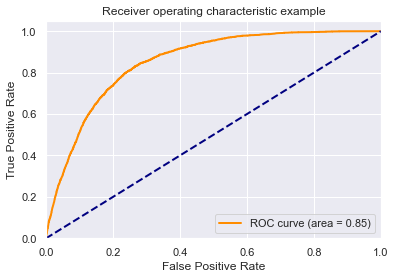

In [110]:
y_train_pred = clf.predict_proba(train_data)[:,1]
plotROC(train_target, y_train_pred)

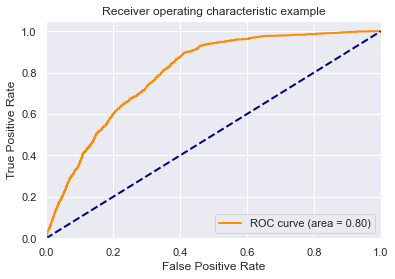

In [111]:
y_pred = clf.predict_proba(test_data)[:,1]
plotROC(test_target, y_pred)

In [112]:
#ks
fpr_lr_train,tpr_lr_train,_ = roc_curve(train_target, y_train_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

fpr_lr,tpr_lr,_ = roc_curve(test_target,y_pred)
test_ks = abs(fpr_lr - tpr_lr).max()
print('test_ks : ',test_ks)

print(((train_ks-test_ks)/test_ks)*100)

train_ks :  0.5646468314923083
test_ks :  0.48370061989142393
16.734775245699364


### lightGBM+opt

In [119]:
train_data

,credit_score,days,time_days_mean,0000-00-00,way1_cnt,qu_xiao_cnt,account_grade_one,sex2,account_grade_four,wan_cheng_cnt,q_o,phone_isnull_y,id_bank_cnt,wechat_bound_one,account_grade_three,qq_bound_one,sex1,account_grade_two,card_2_cnt,auth_info_notnull_num
0,578.0,129,318.461538,0,13,1,0,0,0,12,1768.86,1,6,1,0,0,1,0,2,3
1,402.0,-417,1103.000000,0,2,0,0,1,0,2,0.00,1,5,1,0,1,0,1,2,3
2,579.0,0,-1.000000,0,60,7,0,0,0,31,21.00,1,5,1,0,1,1,0,3,1
3,390.0,-380,-1.000000,0,0,0,0,1,0,0,0.00,1,3,1,0,0,0,0,2,3
4,385.0,56,-1.000000,0,0,0,0,0,0,0,0.00,1,1,1,1,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88757,393.0,228,48.200000,0,0,0,0,1,0,5,0.00,1,1,0,0,1,0,1,0,3
88758,384.0,0,-1.000000,0,0,0,0,0,0,0,0.00,1,2,0,0,0,1,0,0,1
88759,518.0,0,-1.000000,0,0,0,0,0,0,0,0.00,0,1,0,0,0,1,0,0,1
88760,476.0,0,-1.000000,1,1,0,0,0,0,1,0.00,1,1,0,0,0,1,1,1,1


In [127]:
def objective_lgb (params):
    time1 = time.time()
    max_depth = params['max_depth']
    num_leaves = params['num_leaves']
    n_estimators = params['n_estimators']
    boosting_type = params['boosting_type']
    colsample_bytree = params['colsample_bytree']
    learning_rate = params['learning_rate']
    reg_alpha = params['reg_alpha']        
    reg_lambda = params['reg_lambda'] 
    params = {
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'n_estimators':int(params['n_estimators']),
        'boosting_type': params['boosting_type'], 
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']), 
        'learning_rate': '{:.3f}'.format(params['learning_rate']), 
        'reg_alpha':  '{:.3f}'.format(params['reg_alpha']), 
        'reg_lambda': '{:.3f}'.format(params['reg_lambda'])}

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0
    for tr_idx, val_idx in skf.split(train_data, train_target.values.ravel()):
        lgbm = lgb.LGBMClassifier(random_state = 12, **params)


        X_tr, X_vl = train_data.iloc[tr_idx, :], train_data.iloc[val_idx, :]
        y_tr, y_vl = train_target.iloc[tr_idx], train_target.iloc[val_idx]

        lgbm.fit(X_tr, y_tr.values.ravel())
        score = make_scorer(roc_auc_score, needs_proba=True)(lgbm, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, lgbm, score
    return -(score_mean / FOLDS)

In [128]:
LGBM_params_space = {'max_depth': hp.quniform('max_depth', 2, 20, 1),
                     'num_leaves': hp.choice('num_leaves', list(range(10, 100, 10))),
                     'n_estimators': hp.choice('n_estimators', np.arange(10, 100)), 
                     'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss']), 
                     'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0), 
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.1), 
                     'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.5), 
                     'reg_lambda':  hp.uniform('reg_lambda', 0.01, 0.5)}

In [129]:
# Set algoritm parameters
best = fmin(fn=objective_lgb,
            space=LGBM_params_space,
            algo=tpe.suggest,
            max_evals=100)

# Print best parameters
best_params = space_eval(LGBM_params_space, best)

                                                                                
############## New Run ################
params = {'max_depth': 5, 'num_leaves': 90, 'n_estimators': 18, 'boosting_type': 'gbdt', 'colsample_bytree': '0.629', 'learning_rate': '0.049', 'reg_alpha': '0.272', 'reg_lambda': '0.087'}
1 CV - score: 0.8268                                                            
2 CV - score: 0.8253                                                            
3 CV - score: 0.8069                                                            
4 CV - score: 0.8352                                                            
5 CV - score: 0.8071                                                            
Total Time Run: 0.02                                                            
Mean ROC_AUC: 0.8202693687946455                                                
                                                                                
############## New Run ################
pa

1 CV - score: 0.8362                                                            
2 CV - score: 0.831                                                             
3 CV - score: 0.8146                                                            
4 CV - score: 0.8437                                                            
5 CV - score: 0.8164                                                            
Total Time Run: 0.02                                                            
Mean ROC_AUC: 0.8283869148502381                                                
                                                                                
############## New Run ################
params = {'max_depth': 18, 'num_leaves': 80, 'n_estimators': 79, 'boosting_type': 'gbdt', 'colsample_bytree': '0.254', 'learning_rate': '0.062', 'reg_alpha': '0.316', 'reg_lambda': '0.351'}
1 CV - score: 0.8271                                                            
2 CV - score: 0.8275                     

Mean ROC_AUC: 0.8286366720066752                                                
                                                                                
############## New Run ################
params = {'max_depth': 5, 'num_leaves': 20, 'n_estimators': 27, 'boosting_type': 'goss', 'colsample_bytree': '0.610', 'learning_rate': '0.098', 'reg_alpha': '0.401', 'reg_lambda': '0.397'}
1 CV - score: 0.8337                                                            
2 CV - score: 0.8293                                                            
3 CV - score: 0.8112                                                            
4 CV - score: 0.8421                                                            
5 CV - score: 0.8149                                                            
Total Time Run: 0.01                                                            
Mean ROC_AUC: 0.8262426403925556                                                
                                          

1 CV - score: 0.8309                                                            
2 CV - score: 0.8289                                                            
3 CV - score: 0.8057                                                            
4 CV - score: 0.8431                                                            
5 CV - score: 0.811                                                             
Total Time Run: 0.02                                                            
Mean ROC_AUC: 0.8239213352661133                                                
                                                                                
############## New Run ################
params = {'max_depth': 9, 'num_leaves': 80, 'n_estimators': 30, 'boosting_type': 'goss', 'colsample_bytree': '0.891', 'learning_rate': '0.067', 'reg_alpha': '0.474', 'reg_lambda': '0.382'}
1 CV - score: 0.833                                                             
2 CV - score: 0.8286                      

Mean ROC_AUC: 0.8261163910675331                                                
                                                                                
############## New Run ################
params = {'max_depth': 8, 'num_leaves': 20, 'n_estimators': 48, 'boosting_type': 'goss', 'colsample_bytree': '0.793', 'learning_rate': '0.012', 'reg_alpha': '0.498', 'reg_lambda': '0.245'}
1 CV - score: 0.823                                                             
2 CV - score: 0.8242                                                            
3 CV - score: 0.801                                                             
4 CV - score: 0.8341                                                            
5 CV - score: 0.8052                                                            
Total Time Run: 0.02                                                            
Mean ROC_AUC: 0.8174960141120657                                                
                                          

1 CV - score: 0.8378                                                            
2 CV - score: 0.8333                                                            
3 CV - score: 0.8137                                                            
4 CV - score: 0.8451                                                            
5 CV - score: 0.8163                                                            
Total Time Run: 0.03                                                            
Mean ROC_AUC: 0.8292600963599751                                                
                                                                                
############## New Run ################
params = {'max_depth': 3, 'num_leaves': 20, 'n_estimators': 75, 'boosting_type': 'goss', 'colsample_bytree': '0.649', 'learning_rate': '0.083', 'reg_alpha': '0.427', 'reg_lambda': '0.381'}
1 CV - score: 0.8317                                                            
2 CV - score: 0.8325                      

Mean ROC_AUC: 0.8227987307628142                                                
                                                                                
############## New Run ################
params = {'max_depth': 6, 'num_leaves': 80, 'n_estimators': 57, 'boosting_type': 'goss', 'colsample_bytree': '0.419', 'learning_rate': '0.089', 'reg_alpha': '0.490', 'reg_lambda': '0.194'}
1 CV - score: 0.8355                                                            
2 CV - score: 0.8323                                                            
3 CV - score: 0.8129                                                            
4 CV - score: 0.8416                                                            
5 CV - score: 0.8142                                                            
Total Time Run: 0.02                                                            
Mean ROC_AUC: 0.8273037512457847                                                
                                          

1 CV - score: 0.8331                                                            
2 CV - score: 0.8299                                                            
3 CV - score: 0.8107                                                            
4 CV - score: 0.8408                                                            
5 CV - score: 0.8151                                                            
Total Time Run: 0.02                                                            
Mean ROC_AUC: 0.8259307428828858                                                
                                                                                
############## New Run ################
params = {'max_depth': 5, 'num_leaves': 10, 'n_estimators': 50, 'boosting_type': 'gbdt', 'colsample_bytree': '0.619', 'learning_rate': '0.065', 'reg_alpha': '0.388', 'reg_lambda': '0.478'}
1 CV - score: 0.8332                                                            
2 CV - score: 0.8319                      

In [130]:
best_params['max_depth'] = int(best_params['max_depth'])
print("BEST PARAMS: ", best_params)

BEST PARAMS:  {'boosting_type': 'goss', 'colsample_bytree': 0.6859565816531027, 'learning_rate': 0.06856659099679037, 'max_depth': 5, 'n_estimators': 69, 'num_leaves': 20, 'reg_alpha': 0.49876931577113687, 'reg_lambda': 0.43478527981130644}


In [132]:
lgb_model = lgb.LGBMClassifier(    **best_params,n_jobs=-1)
lgb_model.fit(train_data, train_target.values.ravel())

LGBMClassifier(boosting_type='goss', colsample_bytree=0.6859565816531027,
               learning_rate=0.06856659099679037, max_depth=5, n_estimators=69,
               num_leaves=20, reg_alpha=0.49876931577113687,
               reg_lambda=0.43478527981130644)

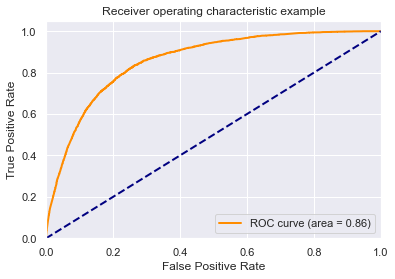

In [134]:
y_train_pred = lgb_model.predict_proba(train_data)[:,1]
plotROC(train_target, y_train_pred)

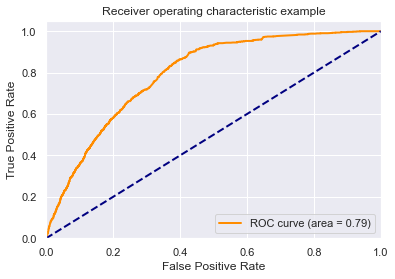

In [136]:
y_pred = lgb_model.predict_proba(test_data)[:,1]
plotROC(test_target, y_pred)

In [137]:
#ks
fpr_lr_train,tpr_lr_train,_ = roc_curve(train_target, y_train_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

fpr_lr,tpr_lr,_ = roc_curve(test_target,y_pred)
test_ks = abs(fpr_lr - tpr_lr).max()
print('test_ks : ',test_ks)

print(((train_ks-test_ks)/test_ks)*100)

train_ks :  0.5713459185685046
test_ks :  0.469515995639879
21.68827555914189


### lightgbm进行特征衍生

In [20]:
train_data.columns

Index(['credit_score', 'days', 'time_days_mean', '0000-00-00', 'way1_cnt',
       'qu_xiao_cnt', 'account_grade_one', 'sex2', 'account_grade_four',
       'wan_cheng_cnt', 'q_o', 'phone_isnull_y', 'id_bank_cnt',
       'wechat_bound_one', 'account_grade_three', 'qq_bound_one', 'sex1',
       'account_grade_two', 'card_2_cnt', 'auth_info_notnull_num'],
      dtype='object')

In [21]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

lgb_train = lgb.Dataset(train_data, train_target, free_raw_data=False)
params = {
    'num_boost_round': 40,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 2,
    'metric': 'auc',
    'max_depth':1,
    'feature_fraction':1,
    'bagging_fraction':1,
}
model = lgb.train(params,lgb_train)
leaf = model.predict(train_data,pred_leaf=True)
lgb_enc = OneHotEncoder()
lgb_enc.fit(leaf)
data_leaf = np.hstack((lgb_enc.transform(leaf).toarray(),train_data))

[LightGBM] [Info] Number of positive: 2452, number of negative: 86310
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 88762, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027624 -> initscore=-3.561041
[LightGBM] [Info] Start training from score -3.561041


In [23]:
leaf_test = model.predict(test_data,pred_leaf=True)
lgb_enc = OneHotEncoder()
lgb_enc.fit(leaf_test)
data_leaf_test = np.hstack((lgb_enc.transform(leaf_test).toarray(),test_data))

In [24]:
data_leaf_test.shape

(32167, 100)

In [25]:
dff_train = pd.DataFrame(data_leaf)
dff_train.columns = [ 'ft' + str(x) for x in range(data_leaf.shape[1])]

dff_val = pd.DataFrame(data_leaf_test)
dff_val.columns = [ 'ft' + str(x) for x in range(data_leaf_test.shape[1])]

- 使用psi进行特殊筛选

In [27]:
feat_lst = list(dff_train.columns)  
psi_df = toad.metrics.PSI(dff_train[feat_lst], dff_val[feat_lst]).sort_values(0)  

In [28]:
psi_df_data=pd.DataFrame(psi_df).reset_index().rename(columns = {'index':'feat',0:'psi'})
feature_lst = list(psi_df_data[psi_df_data['psi']<psi_df_data.quantile(0.6)[0]]['feat'])
len(feature_lst)

60

### 再次建模

- 确定数据

In [29]:
#训练数据
dff_train_data=dff_train[feature_lst]
#跨时间测试数据
dff_val_data=dff_val[feature_lst]

- lightGBM+opt

In [172]:
def objective_lgb (params):
    time1 = time.time()
    max_depth = params['max_depth']
    num_leaves = params['num_leaves']
    n_estimators = params['n_estimators']
    boosting_type = params['boosting_type']
    colsample_bytree = params['colsample_bytree']
    learning_rate = params['learning_rate']
    reg_alpha = params['reg_alpha']        
    reg_lambda = params['reg_lambda'] 
    params = {
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'n_estimators':int(params['n_estimators']),
        'boosting_type': params['boosting_type'], 
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']), 
        'learning_rate': '{:.3f}'.format(params['learning_rate']), 
        'reg_alpha':  '{:.3f}'.format(params['reg_alpha']), 
        'reg_lambda': '{:.3f}'.format(params['reg_lambda'])}

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0
    for tr_idx, val_idx in skf.split(dff_train_data, train_target.values.ravel()):
        lgbm = lgb.LGBMClassifier(random_state = 12, **params)


        X_tr, X_vl = dff_train_data.iloc[tr_idx, :], dff_train_data.iloc[val_idx, :]
        y_tr, y_vl = train_target.iloc[tr_idx], train_target.iloc[val_idx]

        lgbm.fit(X_tr, y_tr.values.ravel())
        score = make_scorer(roc_auc_score, needs_proba=True)(lgbm, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, lgbm, score
    return -(score_mean / FOLDS)

In [173]:
LGBM_params_space = {'max_depth': hp.quniform('max_depth', 2, 20, 1),
                     'num_leaves': hp.choice('num_leaves', list(range(10, 100, 10))),
                     'n_estimators': hp.choice('n_estimators', np.arange(10, 100)), 
                     'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss']), 
                     'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1.0), 
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.1), 
                     'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.5), 
                     'reg_lambda':  hp.uniform('reg_lambda', 0.01, 0.5)}

In [174]:
# Set algoritm parameters
best = fmin(fn=objective_lgb,
            space=LGBM_params_space,
            algo=tpe.suggest,
            max_evals=100)

# Print best parameters
best_params = space_eval(LGBM_params_space, best)

                                                                                
############## New Run ################
params = {'max_depth': 12, 'num_leaves': 50, 'n_estimators': 47, 'boosting_type': 'gbdt', 'colsample_bytree': '0.387', 'learning_rate': '0.082', 'reg_alpha': '0.212', 'reg_lambda': '0.407'}
1 CV - score: 0.7762                                                            
2 CV - score: 0.7874                                                            
3 CV - score: 0.7729                                                            
4 CV - score: 0.7863                                                            
5 CV - score: 0.7823                                                            
Total Time Run: 0.04                                                            
Mean ROC_AUC: 0.7810170123817338                                                
                                                                                
############## New Run ################
p

1 CV - score: 0.7721                                                            
2 CV - score: 0.7813                                                            
3 CV - score: 0.7703                                                            
4 CV - score: 0.7874                                                            
5 CV - score: 0.7802                                                            
Total Time Run: 0.03                                                            
Mean ROC_AUC: 0.7782472403065788                                                
                                                                                
############## New Run ################
params = {'max_depth': 12, 'num_leaves': 20, 'n_estimators': 62, 'boosting_type': 'gbdt', 'colsample_bytree': '0.695', 'learning_rate': '0.076', 'reg_alpha': '0.061', 'reg_lambda': '0.185'}
1 CV - score: 0.7813                                                            
2 CV - score: 0.7897                     

Mean ROC_AUC: 0.7810180674339526                                                
                                                                                
############## New Run ################
params = {'max_depth': 13, 'num_leaves': 10, 'n_estimators': 62, 'boosting_type': 'gbdt', 'colsample_bytree': '0.431', 'learning_rate': '0.074', 'reg_alpha': '0.100', 'reg_lambda': '0.066'}
1 CV - score: 0.778                                                             
2 CV - score: 0.7867                                                            
3 CV - score: 0.7728                                                            
4 CV - score: 0.7856                                                            
5 CV - score: 0.7838                                                            
Total Time Run: 0.03                                                            
Mean ROC_AUC: 0.7813812754146964                                                
                                         

1 CV - score: 0.7761                                                            
2 CV - score: 0.7858                                                            
3 CV - score: 0.7714                                                            
4 CV - score: 0.7874                                                            
5 CV - score: 0.7816                                                            
Total Time Run: 0.03                                                            
Mean ROC_AUC: 0.7804403382044207                                                
                                                                                
############## New Run ################
params = {'max_depth': 14, 'num_leaves': 80, 'n_estimators': 13, 'boosting_type': 'gbdt', 'colsample_bytree': '0.841', 'learning_rate': '0.092', 'reg_alpha': '0.079', 'reg_lambda': '0.086'}
1 CV - score: 0.7723                                                            
2 CV - score: 0.7795                     

Mean ROC_AUC: 0.7797824262583463                                                
                                                                                
############## New Run ################
params = {'max_depth': 20, 'num_leaves': 20, 'n_estimators': 76, 'boosting_type': 'goss', 'colsample_bytree': '0.668', 'learning_rate': '0.068', 'reg_alpha': '0.304', 'reg_lambda': '0.080'}
1 CV - score: 0.7806                                                            
2 CV - score: 0.79                                                              
3 CV - score: 0.773                                                             
4 CV - score: 0.7899                                                            
5 CV - score: 0.7798                                                            
Total Time Run: 0.04                                                            
Mean ROC_AUC: 0.7826623813540602                                                
                                         

1 CV - score: 0.7812                                                            
2 CV - score: 0.7894                                                            
3 CV - score: 0.7742                                                            
4 CV - score: 0.7887                                                            
5 CV - score: 0.7806                                                            
Total Time Run: 0.03                                                            
Mean ROC_AUC: 0.7828159548869813                                                
                                                                                
############## New Run ################
params = {'max_depth': 13, 'num_leaves': 20, 'n_estimators': 76, 'boosting_type': 'gbdt', 'colsample_bytree': '0.690', 'learning_rate': '0.079', 'reg_alpha': '0.172', 'reg_lambda': '0.157'}
1 CV - score: 0.7811                                                            
2 CV - score: 0.7917                     

Mean ROC_AUC: 0.7830876008915806                                                
                                                                                
############## New Run ################
params = {'max_depth': 11, 'num_leaves': 20, 'n_estimators': 89, 'boosting_type': 'gbdt', 'colsample_bytree': '0.578', 'learning_rate': '0.057', 'reg_alpha': '0.196', 'reg_lambda': '0.217'}
1 CV - score: 0.7814                                                            
2 CV - score: 0.7897                                                            
3 CV - score: 0.775                                                             
4 CV - score: 0.7881                                                            
5 CV - score: 0.7841                                                            
Total Time Run: 0.04                                                            
Mean ROC_AUC: 0.7836665472223405                                                
                                         

1 CV - score: 0.7792                                                            
2 CV - score: 0.7901                                                            
3 CV - score: 0.773                                                             
4 CV - score: 0.7888                                                            
5 CV - score: 0.7842                                                            
Total Time Run: 0.04                                                            
Mean ROC_AUC: 0.783045973775828                                                 
                                                                                
############## New Run ################
params = {'max_depth': 13, 'num_leaves': 60, 'n_estimators': 53, 'boosting_type': 'gbdt', 'colsample_bytree': '0.658', 'learning_rate': '0.048', 'reg_alpha': '0.323', 'reg_lambda': '0.114'}
1 CV - score: 0.7757                                                            
2 CV - score: 0.7877                     

In [54]:
best_params['max_depth'] = int(best_params['max_depth'])
print("BEST PARAMS: ", best_params)

lgb_model = lgb.LGBMClassifier(    **best_params,n_jobs=-1)
lgb_model.fit(dff_train_data, train_target.values.ravel())

BEST PARAMS:  {'boosting_type': 'gbdt', 'colsample_bytree': 0.5636439631975408, 'learning_rate': 0.08615500996112828, 'max_depth': 6, 'n_estimators': 76, 'num_leaves': 20, 'reg_alpha': 0.17884665647711223, 'reg_lambda': 0.13689775813114816}


LGBMClassifier(colsample_bytree=0.5636439631975408,
               learning_rate=0.08615500996112828, max_depth=6, n_estimators=76,
               num_leaves=20, reg_alpha=0.17884665647711223,
               reg_lambda=0.13689775813114816)

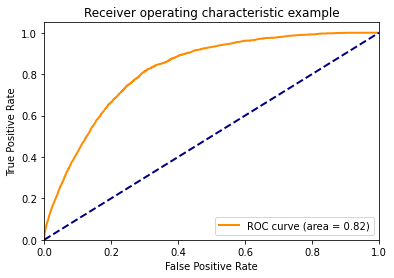

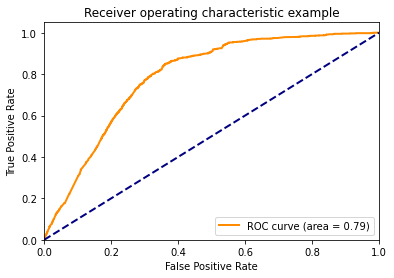

In [55]:
y_train_pred = lgb_model.predict_proba(dff_train_data)[:,1]
plotROC(train_target, y_train_pred)

y_pred = lgb_model.predict_proba(dff_val_data)[:,1]
plotROC(test_target, y_pred)

In [177]:
#ks
fpr_lr_train,tpr_lr_train,_ = roc_curve(train_target, y_train_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

fpr_lr,tpr_lr,_ = roc_curve(test_target,y_pred)
test_ks = abs(fpr_lr - tpr_lr).max()
print('test_ks : ',test_ks)

print(((train_ks-test_ks)/test_ks)*100)

train_ks :  0.5258309182934991
test_ks :  0.49419048490884165
6.402477253380119


xgb

In [30]:
def objective2(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0
    for tr_idx, val_idx in skf.split(dff_train_data, train_target.values.ravel()):
        clf = xgb.XGBClassifier(
            objective="binary:logistic",
            n_estimators=300, random_state=4, verbose=True, 
            tree_method='hist', 
            scale_pos_weight=35,
            n_jobs=-1,
            verbosity = 0,
            **params
        )

        X_tr, X_vl = dff_train_data.iloc[tr_idx, :], dff_train_data.iloc[val_idx, :]
        y_tr, y_vl = train_target.iloc[tr_idx], train_target.iloc[val_idx]
        
        clf.fit(X_tr, y_tr.values.ravel())
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


In [37]:
space2 = {
    'max_depth': hp.quniform('max_depth', 2, 6, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'num_leaves': hp.choice('num_leaves', list(range(10, 100, 10))),
    'min_child_samples': hp.choice('min_child_samples', list(range(10, 200, 20))),
    'subsample': hp.choice('subsample', [0.7, 0.8, 0.9, 1]),
    'feature_fraction': hp.uniform('feature_fraction', 0.7, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1)
}

best2 = fmin(fn=objective2,
            space=space2,
            algo=tpe.suggest,
            max_evals=100)
# Print best parameters
best_params2 = space_eval(space2, best2)

In [40]:
best_params2['max_depth'] = int(best_params2['max_depth'])
print("BEST PARAMS: ", best_params2)

clf2 = xgb.XGBClassifier(
    n_estimators=300,
    **best_params2,
    tree_method='hist',
    eval_metric="auc",
    n_jobs=-1,
    scale_pos_weight=136
)
clf2.fit(dff_train_data, train_target.values.ravel())

BEST PARAMS:  {'bagging_fraction': 0.9375893842468976, 'colsample_bytree': 0.577403244881146, 'feature_fraction': 0.8702136821616395, 'gamma': 0.12890372774548242, 'learning_rate': 0.12402856853674642, 'max_depth': 2, 'min_child_samples': 150, 'num_leaves': 40, 'reg_alpha': 0.2938641095366781, 'reg_lambda': 0.1013861825260674, 'subsample': 0.9}


XGBClassifier(bagging_fraction=0.9375893842468976, base_score=0.5,
              booster='gbtree', callbacks=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.577403244881146,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_fraction=0.8702136821616395,
              gamma=0.12890372774548242, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.12402856853674642, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
              min_child_samples=150, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_leaves=40, num_parallel_tree=1, ...)

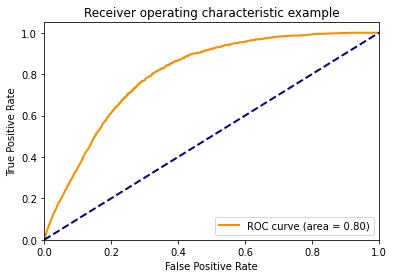

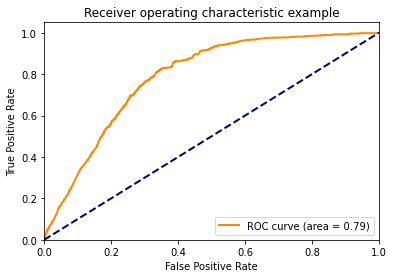

In [45]:
y_train_pred = clf2.predict_proba(dff_train_data)[:,1]
plotROC(train_target, y_train_pred)

y_pred = clf2.predict_proba(dff_val_data)[:,1]
plotROC(test_target, y_pred)

In [49]:
#ks
fpr_lr_train,tpr_lr_train,_ = roc_curve(train_target, y_train_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

fpr_lr,tpr_lr,_ = roc_curve(test_target,y_pred)
test_ks = abs(fpr_lr - tpr_lr).max()
print('test_ks : ',test_ks)

print(((train_ks-test_ks)/test_ks)*100)

train_ks :  0.48012139178117197
test_ks :  0.4769353784194807
0.6680178292181692


## 总结

通过lightgbm特征衍生后，再次建模，测试集auc都在0.79，lightgbm+opt得到最终ks：

- train_ks :  0.5258309182934991
- test_ks :  0.49419048490884165
- 差值6.4%

选出20个特征作为监控特征：

In [57]:
feature_2

0              credit_score
1                      days
2            time_days_mean
3                0000-00-00
4                  way1_cnt
5               qu_xiao_cnt
6         account_grade_one
7                      sex2
8        account_grade_four
9             wan_cheng_cnt
10                      q_o
11           phone_isnull_y
12              id_bank_cnt
13         wechat_bound_one
14      account_grade_three
15             qq_bound_one
16                     sex1
17        account_grade_two
18               card_2_cnt
19    auth_info_notnull_num
Name: name, dtype: object